# Spectral Clustering

**Student: Lucas Versini**


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

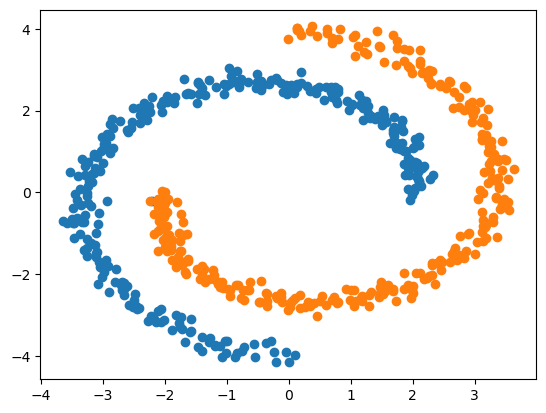

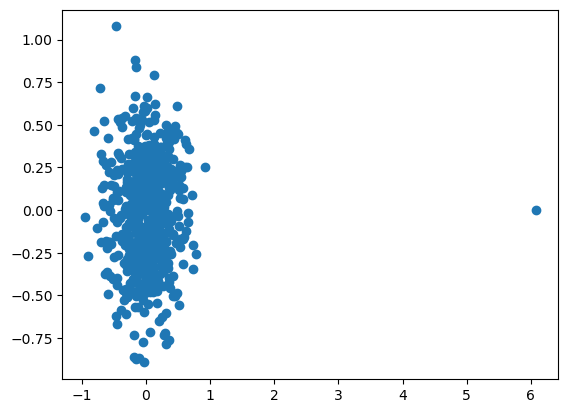

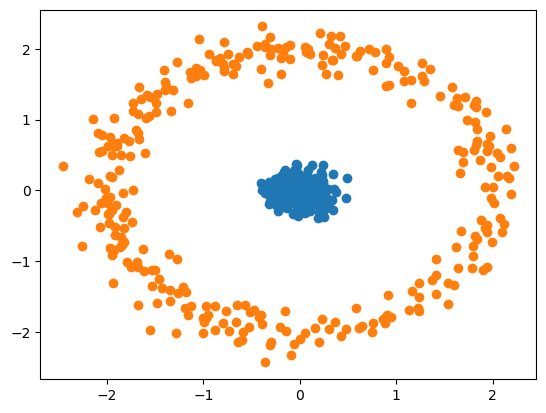

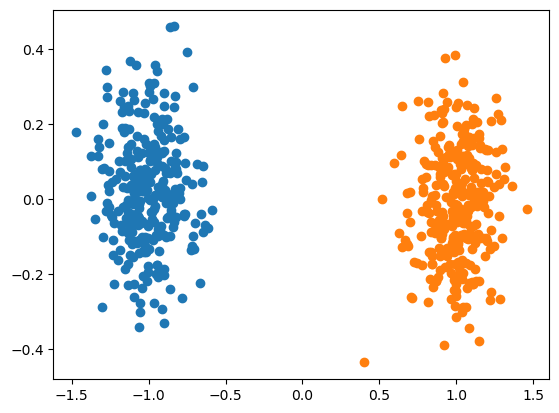

In [2]:
# Example

for fn in [two_moons, worst_case_blob, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
# worst_case_blob?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.8, k=0, option="or"):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph
    option : string
        "or" or "and" for the k-nn graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.exp(-np.sum((X[:, None, :] - X[None, :, :])**2, axis = -1) / (2 * var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities * (similarities >= eps)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        idx = np.argsort(similarities, axis=1)[:, -k:]
        W[np.arange(n)[:, None], idx] = similarities[np.arange(n)[:, None], idx]
        if option == "or":
            W = np.maximum(W, W.T)
        elif option == "and":
            W = np.minimum(W, W.T)

    return W


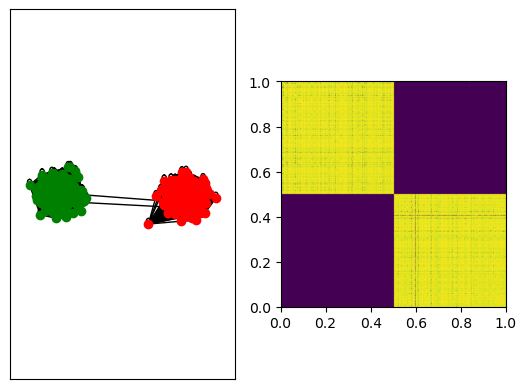

In [4]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

Epsilon graph:


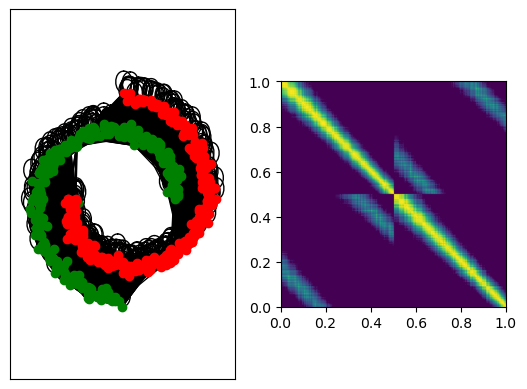

kNN graph with k = 50, 'and':


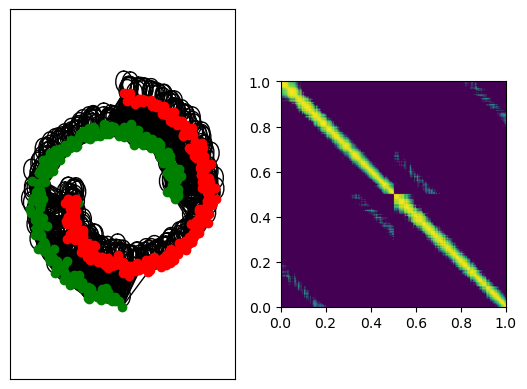

kNN graph with k = 50, 'or':


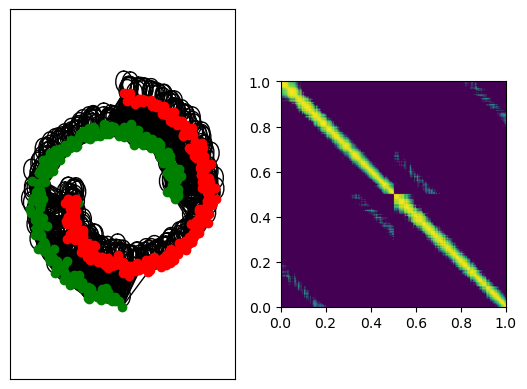

In [5]:
X, Y = two_moons(num_samples=600)

print("Epsilon graph:")
W = build_similarity_graph(X, eps = 0.1)
plot_graph_matrix(X, Y, W)

print("kNN graph with k = 50, 'and':")
W = build_similarity_graph(X, k = 50)
plot_graph_matrix(X, Y, W)

print("kNN graph with k = 50, 'or':")
W = build_similarity_graph(X, k = 50)
plot_graph_matrix(X, Y, W)

## Computing the Laplacian

In [6]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    degree = np.sum(W, axis = 1)
    D = np.diag(degree)

    if laplacian_normalization == 'unn':
        L = D - W
    elif laplacian_normalization == 'sym':
        D_inv_sqrt = np.diag(1 / np.sqrt(degree))
        L = np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_normalization == 'rw':
        D_inv = np.diag(1 / degree)
        L = np.eye(W.shape[0]) - D_inv @ W
    else:
        raise ValueError(f'Unknown normalization mode {laplacian_normalization}')
    
    return L

## Clustering

In [7]:
from scipy.linalg import eigh
from scipy.linalg import eig

def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, option="first"):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)
    option : string
        Option to choose eigenvectors. 
        "first" : choose the first num_classes eigenvectors
        "threshold" : choose eigenvectors corresponding to eigenvalues below a threshold
        "cum_threshold" : choose eigenvectors corresponding to eigenvalues below a cumulative threshold
        "gap" : choose eigenvectors based on a gap heuristic


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    # E, U = eigh(L)
    E, U = eig(L)
    E = np.real(E)
    U = np.real(U)
    idx = np.argsort(E)
    E = E[idx]
    U = U[:, idx]
    # assert np.all(E[:-1] <= E[1:]) # if we want to check if the eigenvalues are sorted

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    if chosen_eig_indices:
        U = U[:, chosen_eig_indices]
    else:
        if option == "first":
            U_ = U[:, :num_classes]
        elif option == "threshold":
            U_ = U[:, E < 1e-4]
        elif option == "cum_threshold":
            E = E / np.sum(E)
            U_ = U[:, np.cumsum(E) < 1e-4]
        elif option == "gap":
            gap = np.diff(E)
            idx = gap.argmax() + 1
            U_ = U[:, :idx]
        
        if U_.shape[1] == 0:
            U_ = U[:, :num_classes]
        U = U_
    Y = KMeans(n_clusters=num_classes).fit_predict(U)
    return Y

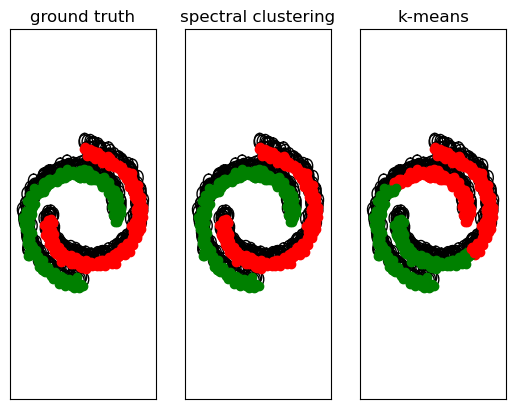

In [8]:
# Example

X, Y = two_moons(num_samples=600)
W = build_similarity_graph(X)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, option = "threshold")

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [9]:
def parameter_sensitivity(parameter_type = "eps"):
    """
    A function to test spectral clustering sensitivity to parameter choice.

    parameter_type : string
        The parameter to test sensitivity to. Either "eps" or "k".
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 2.  # exponential_euclidean's sigma^2
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    if parameter_type == "eps":
        parameter_candidate = np.linspace(0.01, 1.0, 20)
    elif parameter_type == "k":
        parameter_candidate = np.int_(np.linspace(5, 50, 20))
    else:
        raise ValueError(f'Unknown parameter type {parameter_type}')

    list_laplacian_normalization = ['unn', 'sym', 'rw']

    plt.figure()
    for laplacian_normalization in list_laplacian_normalization:
        parameter_performance = []
        for parameter in parameter_candidate:
            # Generate data
            X, Y = two_moons(num_samples, 1, 0.02)
            num_classes = len(np.unique(Y))

            parameter_wrap = {parameter_type: parameter}
            
            W = build_similarity_graph(X, **parameter_wrap, var = var)
            L = build_laplacian(W, laplacian_normalization)

            Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes, option = "first")

            performance = skm.adjusted_rand_score(Y, Y_rec)
            parameter_performance.append(performance)
        plt.plot(parameter_candidate, parameter_performance, label = laplacian_normalization)

    plt.legend()
    plt.xlabel(f'parameter ({parameter_type})')
    plt.ylabel('ARI')
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [10]:
def image_segmentation(input_img='four_elements.bmp', num_classes = 2, var=1., k = 50, laplacian_normalization = 'unn', chosen_eig_indices = None):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    :param num_classes: number of segments to split the image
    :param var: exponential_euclidean's sigma^2
    :param k: number of neighbours for the graph
    :param laplacian_normalization: string selecting which version of the laplacian matrix to construct
    :param chosen_eig_indices: indices of eigenvectors to use for clustering. If None, use adaptive choice of eigenvectors
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

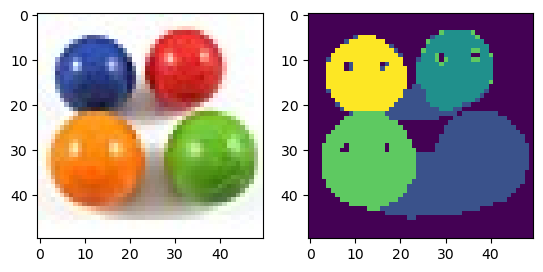

In [11]:
image_segmentation(num_classes = 5)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

**Answer**:
`worst_case_blob` returns one "blob", with one outlier: the last element of `X` is shifted to the right (and its $y$ is set to 0), `delta` indicating how much compared to the point of the blob which has maximum abscissa.

Basically, `delta` quantifies how far this outlier is from the rest of the blob.

Below, we show the result for `delta` equal to 5 and 10.

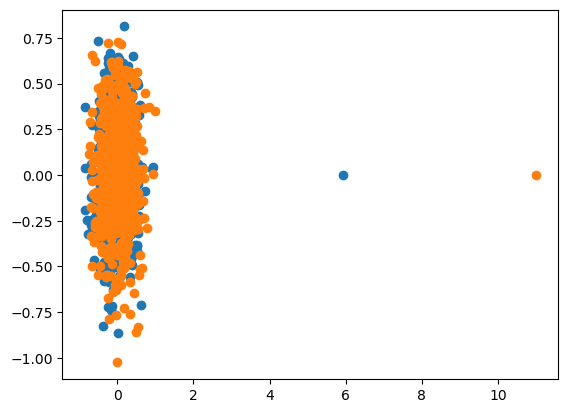

In [12]:
for delta in [5, 10]:
    X, Y = worst_case_blob(num_samples = 600, delta = delta)
    plot_clusters(X, Y)

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

**Answer**:
A *minimum spanning tree* of a connected graph is a subgraph that connects all vertices together (spanning), which has no cycle (tree), and which minimizes the sum of the weights of its edges (minimum).

Therefore, if we have a minimum spanning tree using as weights the opposite of the similarities (because in the end, we want the $\varepsilon$-graph to be connected, so the similarities to be **greater** than $\varepsilon$), we can set $\varepsilon$ to be the opposite of the maximum weight of the edges of this tree (which corresponds to the minimum similarity of these edges), which ensures that the $\varepsilon$-graph is connected.

However, what can happen for the worst case blob is that, in order to keep the graph connected, the value of $\varepsilon$ must be small enough so that the outlier is connected to another node. Hence the low values of $\varepsilon$ observed below when $\delta$ is not too small... As a consequence, many nodes that are not outliers are connected to each other.

However, when $\delta$ is small, we see that less than 25% of the edges are present in the epsilon-graph.

So this approach is not a good idea when there are outliers.

In [13]:
n = 600
var = 1.

def get_epsilon(X, var):
    similarities = np.exp(-np.sum((X[:, None, :] - X[None, :, :])**2, axis = -1) / (2 * var))
    tree = min_span_tree(-similarities)
    epsilon = np.min(similarities[tree])
    return epsilon

for delta in [0.05, 1, 3, 5]:
    X, Y = worst_case_blob(n, delta = delta)
    epsilon = get_epsilon(X, var)
    print(f"Delta = {delta}, Epsilon = {epsilon:.2e}")

    W = build_similarity_graph(X, eps = epsilon)
    print(f"Proportion of edges present in the epsilon-graph: {np.sum(W != 0) / W.size:.4f}\n")

Delta = 0.05, Epsilon = 9.42e-01
Proportion of edges present in the epsilon-graph: 0.2859

Delta = 1, Epsilon = 5.93e-01
Proportion of edges present in the epsilon-graph: 0.9545

Delta = 3, Epsilon = 1.03e-02
Proportion of edges present in the epsilon-graph: 0.9967

Delta = 5, Epsilon = 3.73e-06
Proportion of edges present in the epsilon-graph: 0.9967



### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

**Answer**:
If a graph is not connected, and has $k \geq 2$ connected components, we know the multiplicity of 0 as an eigenvalue of $L$ is $k$. The corresponding eigenvectors will lead k-means to consider different connected components as different clusters. In the case where there are outliers, each outlier may then be a whole cluster, which is not desirable...

More generally:
- For an epsilon-graph, if $\varepsilon$ is small enough then the graph is connected
- For a KNN graph, if $k$ is smaller than the size of each connected component, then points belonging to different connected components will belong to different clusters.

Therefore to have a connected graph, we need $\varepsilon$ small or $k$ large. But $k$ needs to be very large (larger than the size of a connected component), so it *seems* easier to use an epsilon-graph.

However, in the presence of outliers, things are different: with just $k = 1$ (and option "or"), the outlier is connected to another node; whereas for an epsilon-graph, $\varepsilon$ needs to be really low (as seen previously). So in this case, a KNN-graph is easier than an epsilon-graph.

We run some experiments below. For several values of `delta`, we create epsilon-graphs and knn graphs and look at the values of `epsilon` and `k` that make the graph connected, and look at the time required to build these graphs. We see that for large values of `delta`, `epsilon` quickly decreases, whereas `k` is quite stable. We see, however, that constructing the knn graph takes about twice as long as constructing the epsilon-graph.

In [14]:
import time

n = 600
var = 1.

for delta in [1, 3, 5]:
    print(f"Delta = {delta}")
    X, Y = worst_case_blob(n, delta = delta)
    similarities = np.exp(-np.sum((X[:, None, :] - X[None, :, :])**2, axis = -1) / (2 * var))
    
    eps = get_epsilon(X, var)
    t0 = time.time()
    W = build_similarity_graph(X, eps = eps)
    t = time.time() - t0

    print(f"Epsilon = {eps:.2e}; Time to build the graph: {t:.4f}")

    k = 1
    t0 = time.time()
    W = build_similarity_graph(X, k = k)
    t = time.time() - t0
    E, _ = eigh(build_laplacian(W))
    while np.sum(E < 1e-10) > 1:
        k += 1
        t0 = time.time()
        W = build_similarity_graph(X, k = k)
        t = time.time() - t0
        E, _ = eigh(build_laplacian(W))
    print(f"Minimum value of k for the graph to be connected: {k}. Time to build the graph: {t:.4f}\n")

Delta = 1
Epsilon = 5.87e-01; Time to build the graph: 0.0083
Minimum value of k for the graph to be connected: 5. Time to build the graph: 0.0199

Delta = 3
Epsilon = 7.15e-03; Time to build the graph: 0.0092
Minimum value of k for the graph to be connected: 6. Time to build the graph: 0.0200

Delta = 5
Epsilon = 2.71e-06; Time to build the graph: 0.0093
Minimum value of k for the graph to be connected: 5. Time to build the graph: 0.0198



### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

**Answer**:
As said previously, to construct a knn graph for `blobs`, it is enough to use a value of `k` larger than the number of points in each of the two clusters. Below, we use 600 points in total, so 300 per cluster; we then take `k = 320`.

As for the choice of the eigenvectors, we base ourselves on Rayleigh-Ritz theorem, and consider only the second eigenvector. We also plot below the first and second eigenvectors; we see indeed that the first one brings no information (its coordinates are all equal to zero), whereas the second one actually performs clustering.

We see that the groundtruth cluster, the one obtained by spectral clustering, and the one obtained by k-means are all the same.

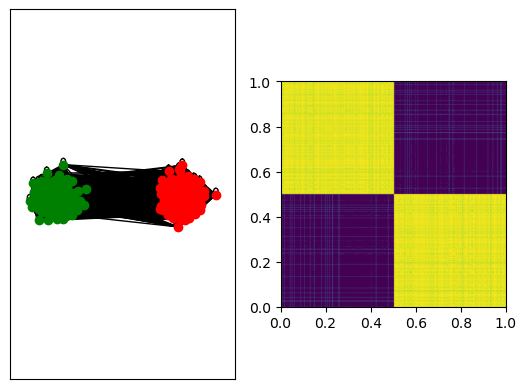

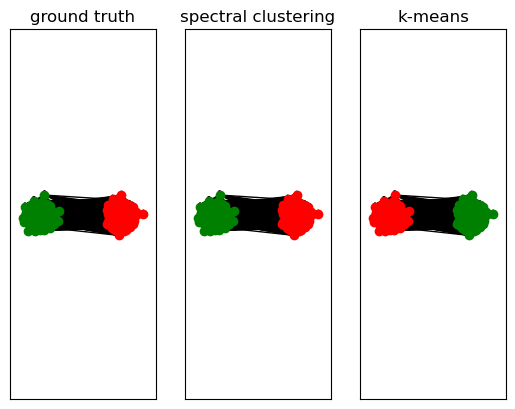

In [15]:
num_classes = 2

X, Y = blobs(num_samples = 600, n_blobs = num_classes)

W = build_similarity_graph(X, eps = 0., k = 320)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices = [1], num_classes = num_classes)

plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

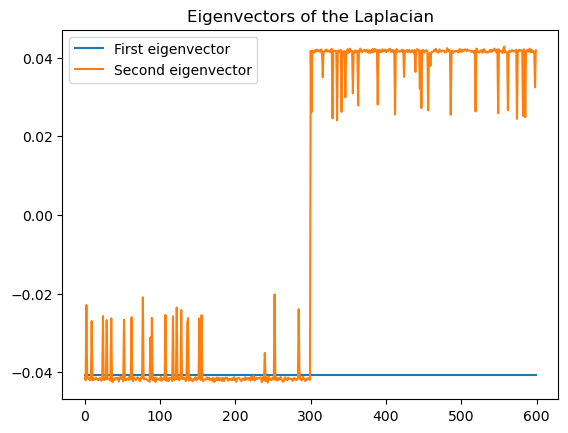

In [16]:
_, U = eigh(L)

plt.figure()
plt.plot(U[:, 0], label = 'First eigenvector')
plt.plot(U[:, 1], label = 'Second eigenvector')
plt.legend()
plt.title('Eigenvectors of the Laplacian')
plt.show()

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

**Answer**:
The graph is the same as before, but this time we use `k = 200`.

We now know that the first eigenvectors of the Laplacian matrix are constant on each connected component of the graph. Therefore, using the first eigenvector is enough to cluster.

We once again plot the first eigenvectors. The first two are indeed zero on one of the components, constant (non-zero) on the other; the third one is different (as we only have two clusters).

We notice once again that groundtruth, spectral clustering, and k-means are the same.

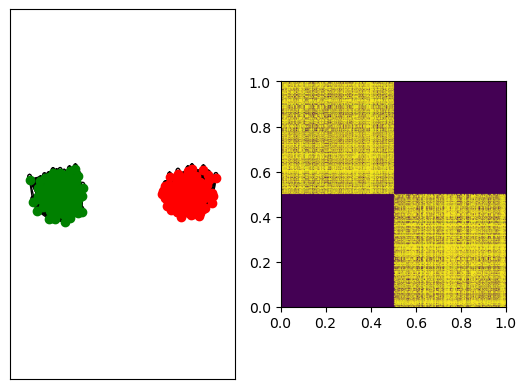

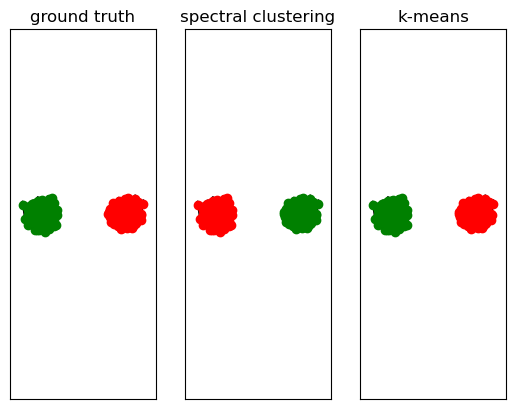

In [17]:
num_classes = 2

X, Y = blobs(num_samples = 600, n_blobs = num_classes)

W = build_similarity_graph(X, eps = 0., k = 200)
L = build_laplacian(W)

Y_rec = spectral_clustering(L, chosen_eig_indices = [0], num_classes = num_classes)

plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

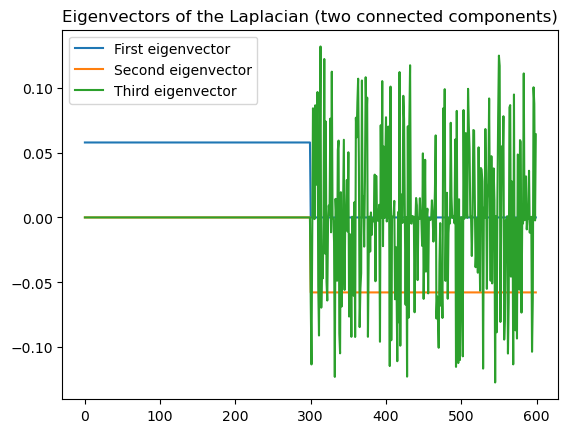

In [18]:
_, U = eigh(L)

plt.figure()
plt.plot(U[:, 0], label = 'First eigenvector')
plt.plot(U[:, 1], label = 'Second eigenvector')
plt.plot(U[:, 2], label = 'Third eigenvector')
plt.legend()
plt.title('Eigenvectors of the Laplacian (two connected components)')
plt.show()

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

**Answer**:
We consider several strategies for the choice of the eigenvectors. All are based on the fact that eigenvectors corresponding to low eigenvalues usually contain a lot of information. We add a parameter `option` to the `spectral_clustering` function, which corresponds to these different strategies.

A remark is that if the graph is connected, then the first eigenvector is constant, and therefore does not bring any information. However, in the case where there are $k \geq 3$ clusters, the first eigenvector helps find one of the clusters, and should therefore be kept (if $k = 2$, then the second eigenvector allows us to find the other cluster, so the first one is not useful). So we decided to keep the first eigenvector in all cases.

- `option = "first"`:
We only keep the first `num_classes` eigenvectors.

- `option = "threshold"`:
We only keep eigenvectors corresponding to eigenvalues lower than some threshold, here $10^{-4}$.

- `option = "cum_threshold"`:
We only keep eigenvectors corresponding to eigenvalues $\lambda_i$ such that $\lambda_1 + \dots + \lambda_k < t$ for some threshold $t$, here $10^{-2}$. Here, we also decided to first normalize the eigenvalues (so they sum up to 1) so that the threshold typically does not need to be modified from one graph to another.

- `option = "gap"`:
We keep eigenvectors $u_1, \dots, u_k$, where $k$ is such that $\lambda_{k + 1} - \lambda_k = \max\limits_i (\lambda_{i + 1} - \lambda_i)$: we stop at the eigenvalue followed by a large gap.

To evaluate each clustering, we use the "Rand index adjusted for chance" (ARI) from `skm.adjusted_rand_score`.

Here are some of the results we obtained (which are random, because they depend on the points initialization for instance):

Option | Blob variance | ARI
--- | --- | ---
First | 0.15 | 1.00
First | 0.3 | 0.95
First | 0.5 | 0.61
Threshold | 0.15 | 1.00
Threshold | 0.3 | 0.64
Threshold | 0.5 | 0.25
Cumulative threshold | 0.15 | 1.00
Cumulative threshold | 0.3 | 0.94
Cumulative threshold | 0.5 | 0.65
Gap | 0.15 | 1.00
Gap | 0.3 | 0.96
Gap | 0.5 | 0.66

Overall, the "gap" method performs better than the others for all values variances.

In [19]:
num_classes = 4

for option in ["first", "threshold", "cum_threshold", "gap"]:
    print(f"Option: {option}")
    for blob_var in [0.15, 0.3, 0.5]:
        X, Y = blobs(num_samples = 600, n_blobs = num_classes, blob_var = blob_var)

        W = build_similarity_graph(X, eps = 0., k = 150)
        L = build_laplacian(W)

        Y_rec = spectral_clustering(L, chosen_eig_indices = None, num_classes = num_classes, option = option)

        print(f"Blob variance: {blob_var}, ARI: {skm.adjusted_rand_score(Y, Y_rec):.4f}")
        # plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
    print()

Option: first
Blob variance: 0.15, ARI: 1.0000
Blob variance: 0.3, ARI: 0.9431
Blob variance: 0.5, ARI: 0.6332

Option: threshold
Blob variance: 0.15, ARI: 1.0000
Blob variance: 0.3, ARI: 0.3719
Blob variance: 0.5, ARI: 0.1644

Option: cum_threshold
Blob variance: 0.15, ARI: 1.0000
Blob variance: 0.3, ARI: 0.6732
Blob variance: 0.5, ARI: 0.2514

Option: gap
Blob variance: 0.15, ARI: 1.0000
Blob variance: 0.3, ARI: 0.9646
Blob variance: 0.5, ARI: 0.0996



### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

**Answer**:
We mostly used the k-means method. This is because thresholding requires to tune a threshold, which is not an easy task; for k-means, everything is done automatically (by greedily minimizing some objective function).

We tried using thresholding, but the results became quite bad for large values of the blob variance.

Thresholding should be used in general when we *know* that the eigenvectors are simple (e.g., positive or negative, such as when we have eigenvectors associated to eigenvalues 0, i.e., connected components), which in this case is mostly the case for low variances.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

**Answer**:
We see that spectral clustering performs very well, whereas k-means performs poorly, by clustering points which are close (in terms of euclidean distance) but not in the same component.

In fact, when using k-means with $k = 2$, we use two centroids; each point in then clustered based on which centroid is the closest. And given two centroids $c_1 \neq c_2$, the set $\{ x \mid \| x - c_1 \|_2 \leq \| x - c_2 \|_2 \}$ is a half-plane (because $\| x - c_1 \|_2 \leq \| x - c_2 \|_2 \iff \| x - c_1 \|_2^2 \leq \| x - c_2 \|_2^2 \iff \langle c_2 - c_1, x \rangle \leq \frac12 (\| c_2 \|_2^2 - \|c_1 \|_2^2)$). This indeed matches what we see below.

And of course, for the two-moons dataset, a simple hyperplane is not enough to perform well.

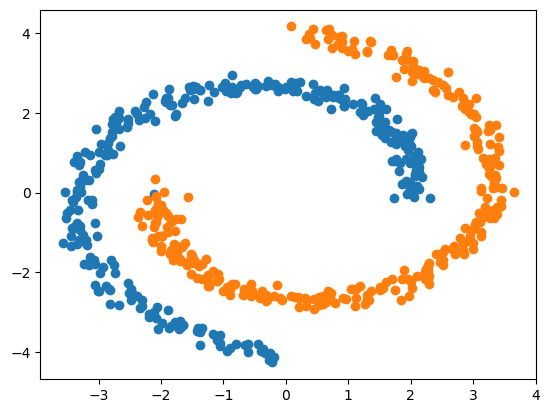

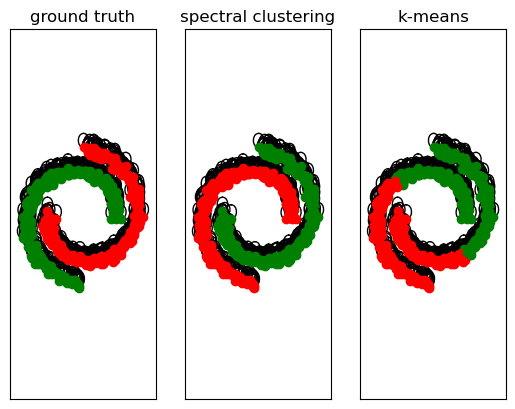

In [20]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

W = build_similarity_graph(X, eps = 0.8)
L = build_laplacian(W)

Y_rec = spectral_clustering(L, chosen_eig_indices = None, num_classes = 2, option = "threshold")

plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

**Answer**:
Below, we use epsilon-graphs as well as knn-graphs.

We see that most of the time (that is, for many hyperparameters configurations), clustering using the random-walk regularized Laplacian performs better than the normal Laplacian.

More precisely, for large values of `epsilon` both methods work well (`epsilon` large means we only consider points close to each other, which on this specific dataset works very well), and the same thing holds for low values of `k` (for the same reason).

However, for low values of `epsilon` of large values of `k`, both methods struggle, with an advantage to the random-walk regularized Laplacian.

We know that the random-walk regularized Laplacian is particularly useful to approximate NCut (where we want to balance the volume of the clusters); the normal Laplacian is useful to approximate RatioCut (where we want to balance the number of vertices in the clusters).

Here, on this specific dataset, what is important is the weights on the edges (i.e., the similarities), and therefore NCut seems more appropriate (because the volume is directly linked to the weights) than RatioCut, hence the observed results.

Epsilon: 0.1
ARI (normal Laplacian): 0.1148


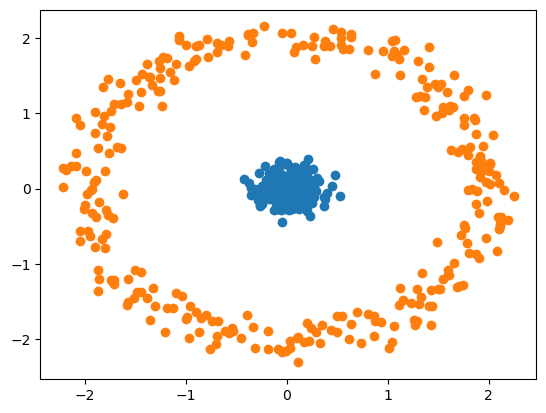

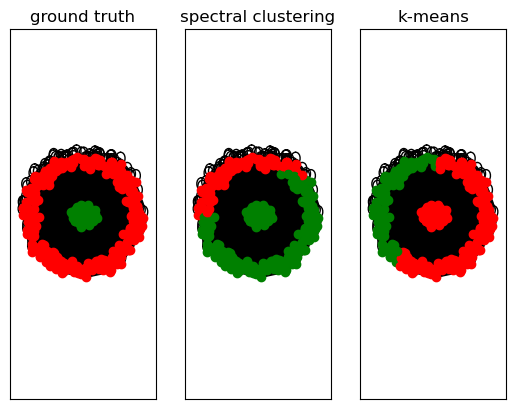

ARI (random walk normalization): 0.1287



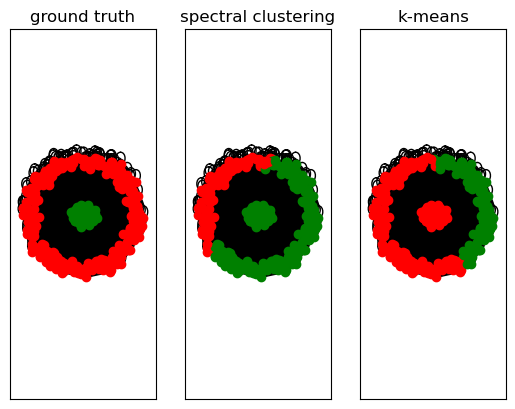

Epsilon: 0.2
ARI (normal Laplacian): 0.1217
ARI (random walk normalization): 0.9087

Epsilon: 0.3
ARI (normal Laplacian): 1.0000
ARI (random walk normalization): 1.0000

Epsilon: 0.4
ARI (normal Laplacian): 1.0000
ARI (random walk normalization): 1.0000

Epsilon: 0.5
ARI (normal Laplacian): 1.0000
ARI (random walk normalization): 1.0000



In [21]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f"Epsilon: {eps}")
    W = build_similarity_graph(X, eps = eps)

    # normal Laplacian
    L = build_laplacian(W, laplacian_normalization = 'unn')
    Y_rec = spectral_clustering(L, num_classes = num_classes)
    print(f"ARI (normal Laplacian): {skm.adjusted_rand_score(Y, Y_rec):.4f}")
    if eps == 0.1:
        plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

    # random walk normalization
    L = build_laplacian(W, laplacian_normalization = 'rw')
    Y_rec = spectral_clustering(L, num_classes = num_classes)
    print(f"ARI (random walk normalization): {skm.adjusted_rand_score(Y, Y_rec):.4f}\n")
    if eps == 0.1:
        plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

k: 20


ARI (normal Laplacian): 1.0000
ARI (random walk normalization): 1.0000

k: 50
ARI (normal Laplacian): 1.0000
ARI (random walk normalization): 1.0000

k: 100
ARI (normal Laplacian): 0.3052
ARI (random walk normalization): 0.3433



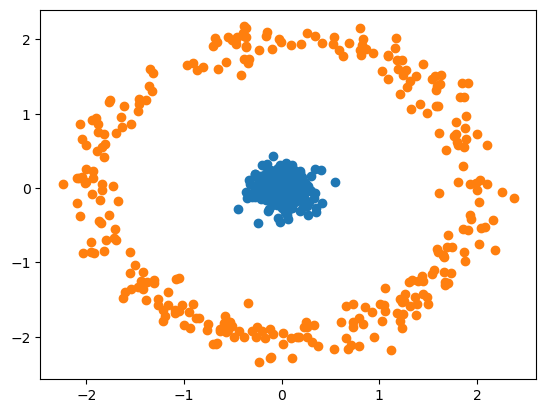

In [22]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

for k in [20, 50, 100]:
    print(f"k: {k}")
    W = build_similarity_graph(X, k = k)

    # normal Laplacian
    L = build_laplacian(W, laplacian_normalization = 'unn')
    Y_rec = spectral_clustering(L, num_classes = num_classes)
    print(f"ARI (normal Laplacian): {skm.adjusted_rand_score(Y, Y_rec):.4f}")

    # random walk normalization
    L = build_laplacian(W, laplacian_normalization = 'rw')
    Y_rec = spectral_clustering(L, num_classes = num_classes)
    print(f"ARI (random walk normalization): {skm.adjusted_rand_score(Y, Y_rec):.4f}\n")

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

**Answer**:
We observe for the different types of Laplacian that the choice of `epsilon` and `k` is very important, as the result highly depends on it (as we already explained in Q2.6.): high values of `epsilon` (but, of course, below 1) and low values of `k` are preferable here.

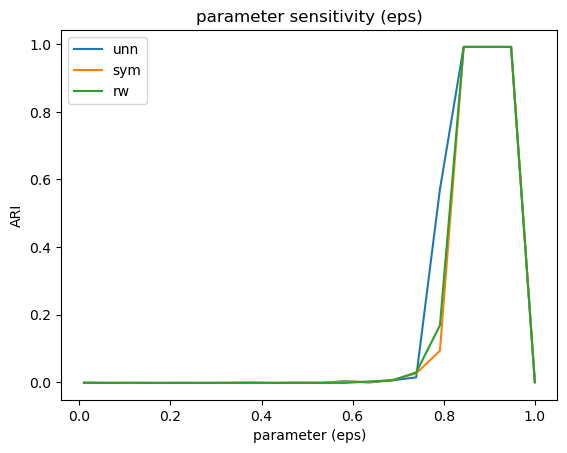

In [23]:
parameter_sensitivity("eps")

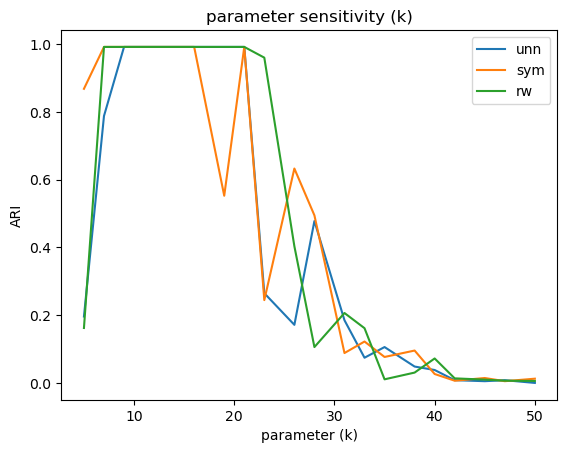

In [24]:
parameter_sensitivity("k")

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

**Answer**:
If we do not have access to "true" labels, we can use [modularity](https://arxiv.org/abs/cond-mat/0308217).

For a graph $(V, E)$, if $C(i)$ is the estimated class of node $i$, the modularity is defined as
$$
\frac{1}{2 D} \sum_{i, j \in V} \left( W_{i, j} - \frac{d_i d_j}{2 D} \right) \mathbb{1}_{C(i) = C(j)},
$$
where $d_i = \sum\limits_{k \in V} W_{i, k}$ and $D = \sum\limits_{i \in V} d_i$.

Modularity measures the density of connections intra-clusters and inter-clusters. It is the fraction of edges that fall within the given groups, minus the expected fraction if all edges were distributed at random.

Below, we implement the modularity, and observe that it is better for spectral clustering than for k-means (on an example where, clearly, spectral clustering performs better).

In [25]:
def modularity(W, Y):
    D = np.sum(W)
    d = np.sum(W, axis = 1)
    d_i_d_j = np.outer(d, d)
    C_i_C_j = Y[:, None] == Y[None, :]
    
    return ((W - d_i_d_j / D) * C_i_C_j).sum() / (2 * D)

Modularity (spectral clustering): 0.1173
Modularity (KMeans): 0.0564


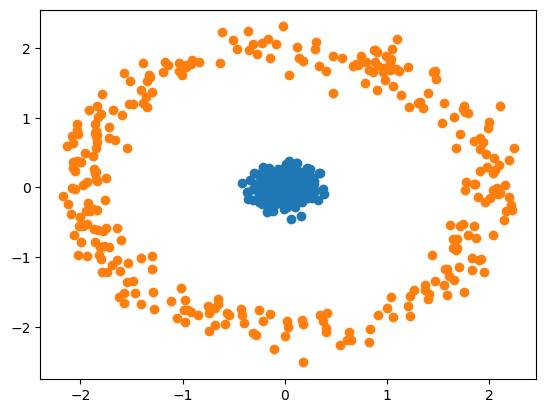

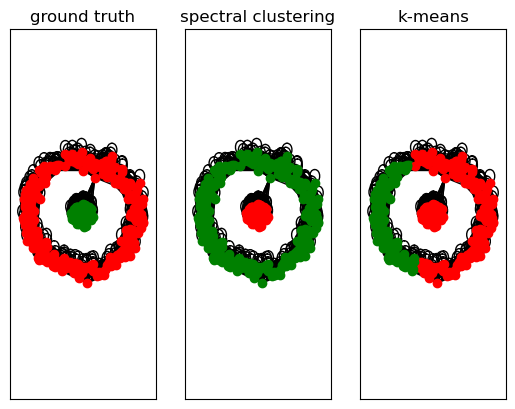

In [26]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

num_classes = 2

eps = 0.5

W = build_similarity_graph(X, eps = eps)

L = build_laplacian(W, laplacian_normalization = 'unn')
Y_rec = spectral_clustering(L, num_classes = num_classes)
Y_kmeans = KMeans(num_classes).fit_predict(X)

print(f"Modularity (spectral clustering): {modularity(W, Y_rec):.4f}")
print(f"Modularity (KMeans): {modularity(W, Y_kmeans):.4f}")

plot_clustering_result(X, Y, L, Y_rec, Y_kmeans)

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

**Answer**:
We use a knn-graph, with $k = 50$, `laplacian_normalization = "rw"`. For "four_elements.bmp", we use 5 classes (4 balls, 1 background), and for the fruit salad, we use 4 classes.

The results are a bit noisy, but rather accurate.

We also show what happens when we use the wrong number of classes (8 instead of 5 for "four_elements.bmp"), and we see that the result is really noisy (the background is segmented into several classes).

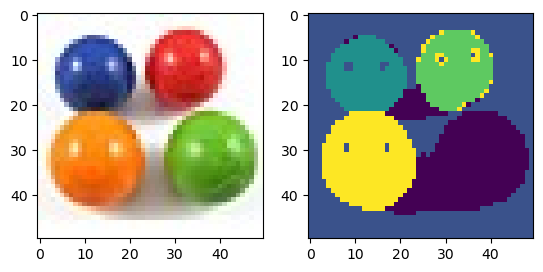

In [27]:
image_segmentation(input_img = 'four_elements.bmp', num_classes = 5, laplacian_normalization = 'rw')

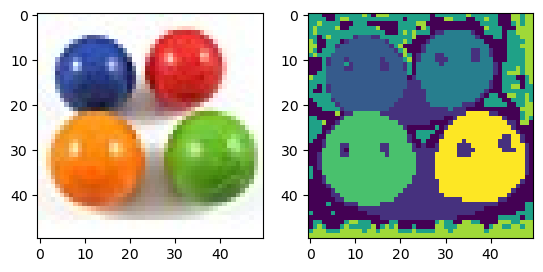

In [28]:
image_segmentation(input_img = 'four_elements.bmp', num_classes = 8, laplacian_normalization = 'rw')

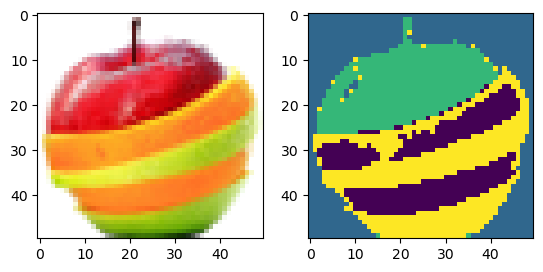

In [29]:
image_segmentation(input_img = 'fruit_salad.bmp', num_classes = 4, var = .1, laplacian_normalization = 'rw')

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

**Answer**:
A possibility would be to first downsample the image, to get an image of reasonable size. Then, we perform spectral clustering like before. Finally, we upsample the image.

Another possibility would be, instead of downsampling the image (i.e., grouping nearby pixels), to group pixels that are similar. The rest is the same: the image is small, we thus apply what was done previously.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

**Answer**:
We use [this image](https://m.media-amazon.com/images/I/81MbS41+wFL.jpg), saved under the name "fruits.bmp" in the `data` folder, and [this image](https://omarchefrais-magasins.com/wp-content/uploads/2021/02/me%CC%81lange-de-fruits-a%CC%80-coque.jpg), saved under the name "nut_fruit.bmp" in the `data` folder. We use the downsampling strategy.

The result is quite good (of course the contours are not perfect, but they are rather accurate, and the code runs rather quickly).

Of course, we notice a trade-off when choosing the value of the down-sampling factor: if it is too low, then the segmentation is better, but it takes a long time; if it is too large, then it is faster, but the quality is not as good.

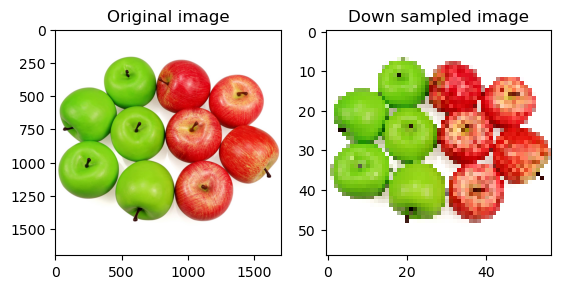

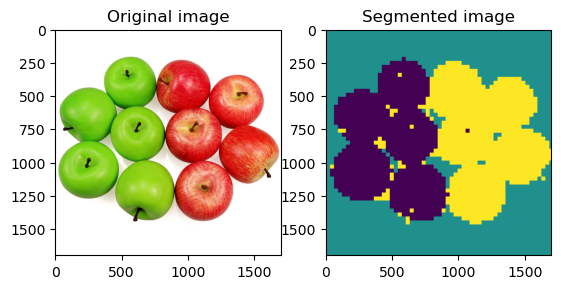

In [30]:
path = 'data/fruits.bmp'

num_classes = 3
factor = 30 # down sampling factor

image = io.imread(path)[:, :, :3]
m, n, l = image.shape

X = (image - np.min(image)) / (np.max(image) - np.min(image))

image2 = X[::factor, ::factor] # down sample the image

# Show original and down sampled image
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Down sampled image")

plt.show()

# Cluster
Xr = image2.reshape(-1, 3)
W = build_similarity_graph(Xr, var = 1.0, k = 40)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes = num_classes).reshape(image2.shape[:2])

# Up sampling
image3 = np.zeros((m, n))
image3[::factor, ::factor] = Y_rec
image3[:, :] = np.repeat(image3[::factor, :], factor, axis = 0)[:m, :]
image3[:, :] = np.repeat(image3[:, ::factor], factor, axis = 1)[:, :n]

# Show original and segmented image
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(image3)
plt.title("Segmented image")

plt.show()

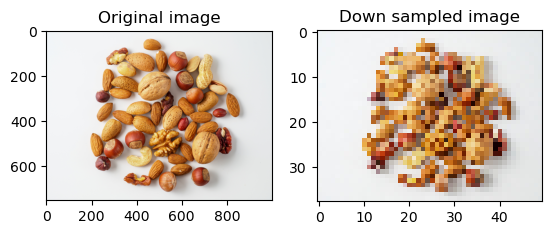

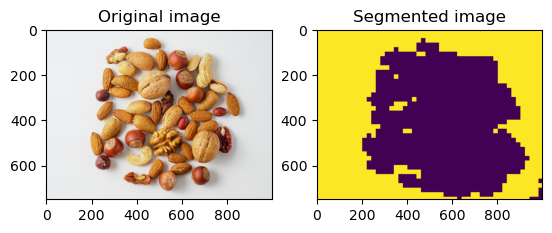

In [31]:
path = 'data/nut_fruit.bmp'

num_classes = 2
factor = 20 # down sampling factor

image = io.imread(path)[:, :, :3]
m, n, l = image.shape

X = (image - np.min(image)) / (np.max(image) - np.min(image))

image2 = X[::factor, ::factor] # down sample the image

# Show original and down sampled image
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Down sampled image")

plt.show()

# Cluster
Xr = image2.reshape(-1, 3)
W = build_similarity_graph(Xr, var = 2.0, k = 50)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, None, num_classes = num_classes).reshape(image2.shape[:2])

# Up sampling
image3 = np.zeros((m, n))
image3[::factor, ::factor] = Y_rec
image3[:, :] = np.repeat(image3[::factor, :], factor, axis = 0)[:m, :]
image3[:, :] = np.repeat(image3[:, ::factor], factor, axis = 1)[:, :n]

# Show original and segmented image
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(image3)
plt.title("Segmented image")

plt.show()